PROJECT DESCRIPTION:
In this project a decision tree classifier model was developed with the goal of providing actionable insights into patient care. The model's core function is to predict the probable success or failure of a prescribed treatment plan, leveraging a dataset of patient information. This includes biological data such as the patient's blood group, their medical condition(s), the specific medication(s) they were receiving, their age, and other health metrics. The power of this model holds significant promise for optimizing treatment protocols, enabling more informed decision-making, and ultimately contributing to improved patient outcomes by foreseeing the trajectory of their therapeutic journey.

IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from category_encoders  import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

DATA PREPARATION

Create a wrangle function for cleaning the data

In [2]:
def wrangle(filepath):
    
    # Load csv file to dataframe
    df = pd.read_csv(filepath)

    # Create a new column 'Billing Amount [USD]' from 'Billing Amount'
    df["Billing Amount [USD]"] = df["Billing Amount"].round(2)
    df = df[df["Billing Amount [USD]"] > 0]

    # Drop old 'Billing Amount' column
    drop_cols = ["Billing Amount"]

    # Search and drop duplicated rows
    df.drop_duplicates(inplace=True, keep="first")

    # Create binary target column, 'Outcome' from 'Test Results' column: '1' for normal '0' for Abnormal/inconclusive
    df["Outcome"] = [1 if i == "Normal" else 0 for i in df["Test Results"]]
    
    # Drop old column 'Test Results'
    drop_cols.append("Test Results")
    
    # Drop high cardinality columns
    drop_cols.extend(
        ["Name", "Doctor", "Hospital", "Room Number", "Date of Admission", "Discharge Date"]
    )

    # Assuming the different 'Insurance Providers' represent different regions
    regions = {
        "Aetna": "Region 1",
        "Blue Cross": "Region 2",
        "Cigna": "Region 3",
        "Medicare": "Region 4",
        "UnitedHealthcare": "Region 5"    
    }
    df["Region"] = df["Insurance Provider"].replace(regions)
    
    # Drop old column 'Insurance Provider'
    drop_cols.append("Insurance Provider")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [24]:
df = wrangle("healthcare_dataset.csv")

print("df type", type(df))
print("df Shape", df.shape)
df.head()

df type <class 'pandas.core.frame.DataFrame'>
df Shape (54860, 9)


,Age,Gender,Blood Type,Medical Condition,Admission Type,Medication,Billing Amount [USD],Outcome,Region
0,30,Male,B-,Cancer,Urgent,Paracetamol,18856.28,1,Region 2
1,62,Male,A+,Obesity,Emergency,Ibuprofen,33643.33,0,Region 4
2,76,Female,A-,Obesity,Emergency,Aspirin,27955.10,1,Region 1
3,28,Female,O+,Diabetes,Elective,Ibuprofen,37909.78,0,Region 4
4,43,Female,AB+,Cancer,Urgent,Penicillin,14238.32,0,Region 1


DATA EXPLORATION

In [28]:
# Statistical Analysis of dataframe 'df'
df[["Age", "Billing Amount [USD]"]].describe()

,Age,Billing Amount [USD]
count,54860.000000,54860.000000
mean,51.533850,25594.633612
std,19.605295,14175.867046
min,13.000000,9.240000
25%,35.000000,13299.750000
50%,52.000000,25593.875000
75%,68.000000,37847.065000
max,89.000000,52764.280000


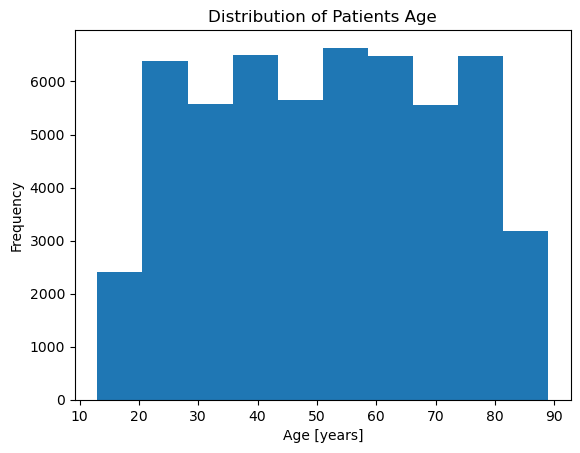

In [30]:
# Histogram plot of 'Age'
plt.hist(
    df["Age"]
)
plt.xlabel("Age [years]")
plt.ylabel("Frequency")
plt.title("Distribution of Patients Age")
plt.show();

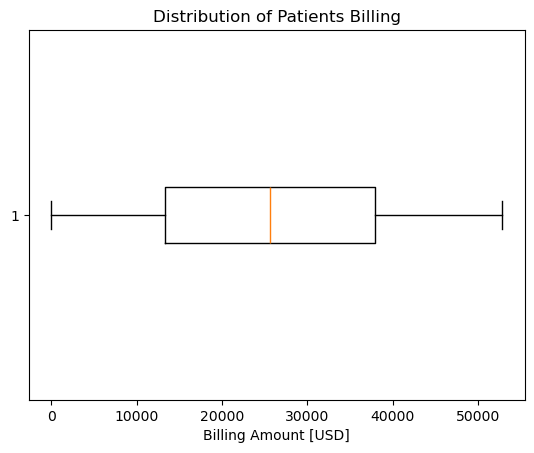

In [32]:
# Boxplot of 'Billing Amount [USD]'
plt.boxplot(df["Billing Amount [USD]"], vert=False)

plt.xlabel("Billing Amount [USD]")
plt.title("Distribution of Patients Billing")
plt.show();

DATA VISUALIZATION

Create Bar Chart to visualize the Population of Patients with various Medical Conditions by Region

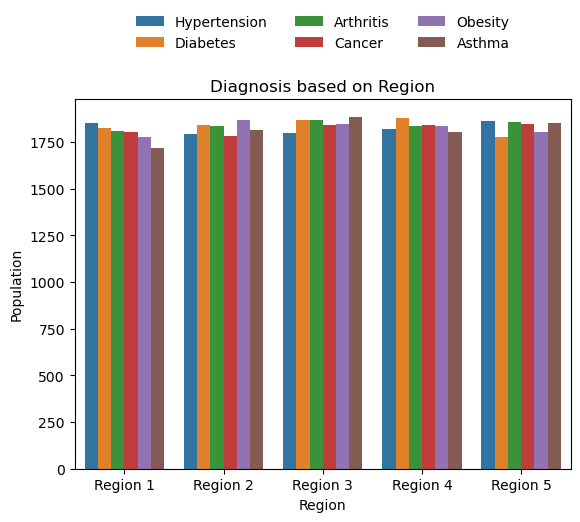

In [35]:
region_diag = df["Medical Condition"].groupby(df["Region"]).value_counts().to_frame()

fig = sns.barplot(
    data=region_diag, 
    x="Region", 
    y="count",
    hue="Medical Condition"
)
sns.move_legend(fig, "lower center", bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False)
plt.xlabel("Region")
plt.ylabel("Population")
plt.title("Diagnosis based on Region");

Create Pie Chart to visualize the Success rate of the various Treatment Plans

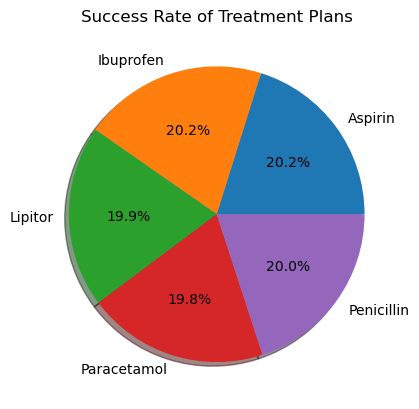

In [38]:
# Subset df to only successful outcomes 
df_success = df[df["Outcome"]==1]
mask = ["Medication", "Outcome"]
success_rate = df_success[mask]
success_percent = (
    success_rate
    .groupby("Medication")
    .sum()
)

# Create pie chart of success_percent
success_percent.plot.pie(
    y="Outcome", 
    title="Success Rate of Treatment Plans", 
    legend=False, 
    autopct='%1.1f%%', 
    startangle=0, 
    ylabel="",
    shadow=True
);

Create Bar Chart to visualize the Age, Medical Condition and Gender of the Patients

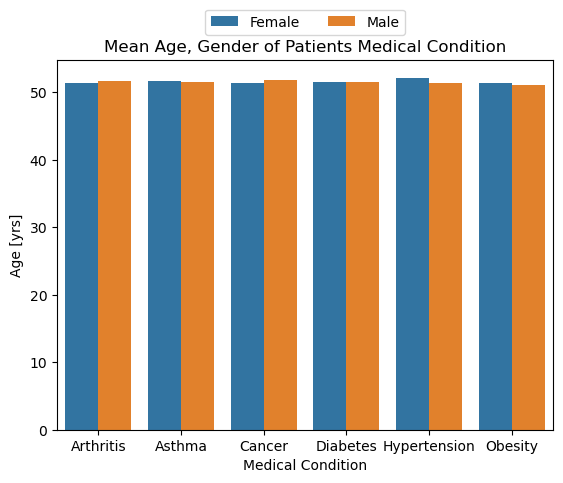

In [43]:
mask = ["Age", "Gender", "Medical Condition"]
df_demo = df[mask].groupby(["Medical Condition", "Gender"]).mean("age").round(2)

fig = sns.barplot(
    data=df_demo, 
    x="Medical Condition", 
    y="Age",
    hue="Gender"
)
sns.move_legend(fig, "lower center", bbox_to_anchor=(.5, 1.05), ncol=2,  title=None)
plt.xlabel("Medical Condition")
plt.ylabel("Age [yrs]")
plt.title("Mean Age, Gender of Patients Medical Condition");

Create a Bar Chart to visualize the Class Balance of the 'Outcome' column

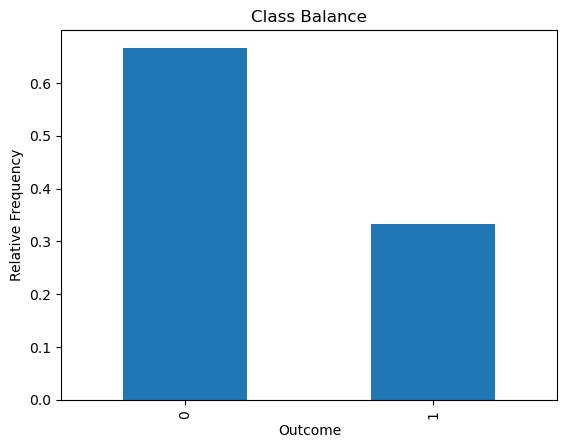

In [46]:
# Plot value counts of 'Outcome'
df["Outcome"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Outcome", ylabel="Relative Frequency", title="Class Balance"
);


DATA SPLIT

Create feature matrix X and target vector y

In [48]:
X = df[["Age", "Medical Condition", "Medication"]]
y = df["Outcome"]

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(" X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:",  y_test.shape)

 X_train shape: (43888, 3)
y_train shape: (43888,)
X_test shape: (10972, 3)
y_test shape: (10972,)


Further split training data into training and validation

In [53]:
X_train, X_val , y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print(" X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:",  y_val.shape)

 X_train shape: (35110, 3)
y_train shape: (35110,)
X_val shape: (8778, 3)
y_val shape: (8778,)


BUILD MODEL

Calculate baseline accuracy score

In [55]:
acc_baseline = y.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 3))

Baseline Accuracy: 0.666


Build and train Decision Tree model

In [58]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(random_state=42)
)
# Fit model to training data
model.fit(X_train, y_train)
check_is_fitted(model)

Find the depth of our decision tree model 

In [61]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 20


In [63]:
depth_hyperparams = range(1, 25, 2)

In [70]:
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with 'max_depth' of d
    test_model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )

    # Fit model to training data
    test_model.fit(X_train, y_train)

    # Calculate training accuracy score and append to 'training_acc'
    training_acc.append(test_model.score(X_train, y_train))

    # Calculate validation accuracy score and append to 'validation_acc_'
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:4])
print("Validation Accuracy Scores:", validation_acc[:4])

Training Accuracy Scores: [0.6660780404443178, 0.6660780404443178, 0.6660780404443178, 0.6664198234121333]
Validation Accuracy Scores: [0.6670084301663249, 0.6670084301663249, 0.6670084301663249, 0.6663249031670084]


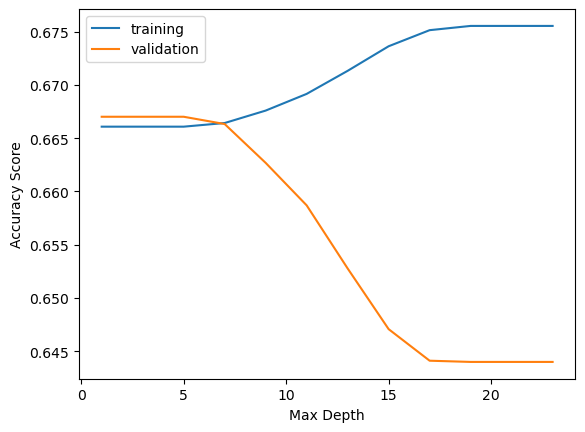

In [66]:
# Plot 'depth_hyperparams', training_acc
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

Build Final Model

In [72]:
# Build final model
final_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(max_depth=5 ,random_state=42)
)
# Fit model to training data
final_model.fit(X_train, y_train)
check_is_fitted(final_model)

Calculate Accuracy Score of Final Model

In [75]:
test_acc = final_model.score(X_test, y_test)
print("Test Accuracy Score:", round(test_acc, 3))

Test Accuracy Score: 0.667


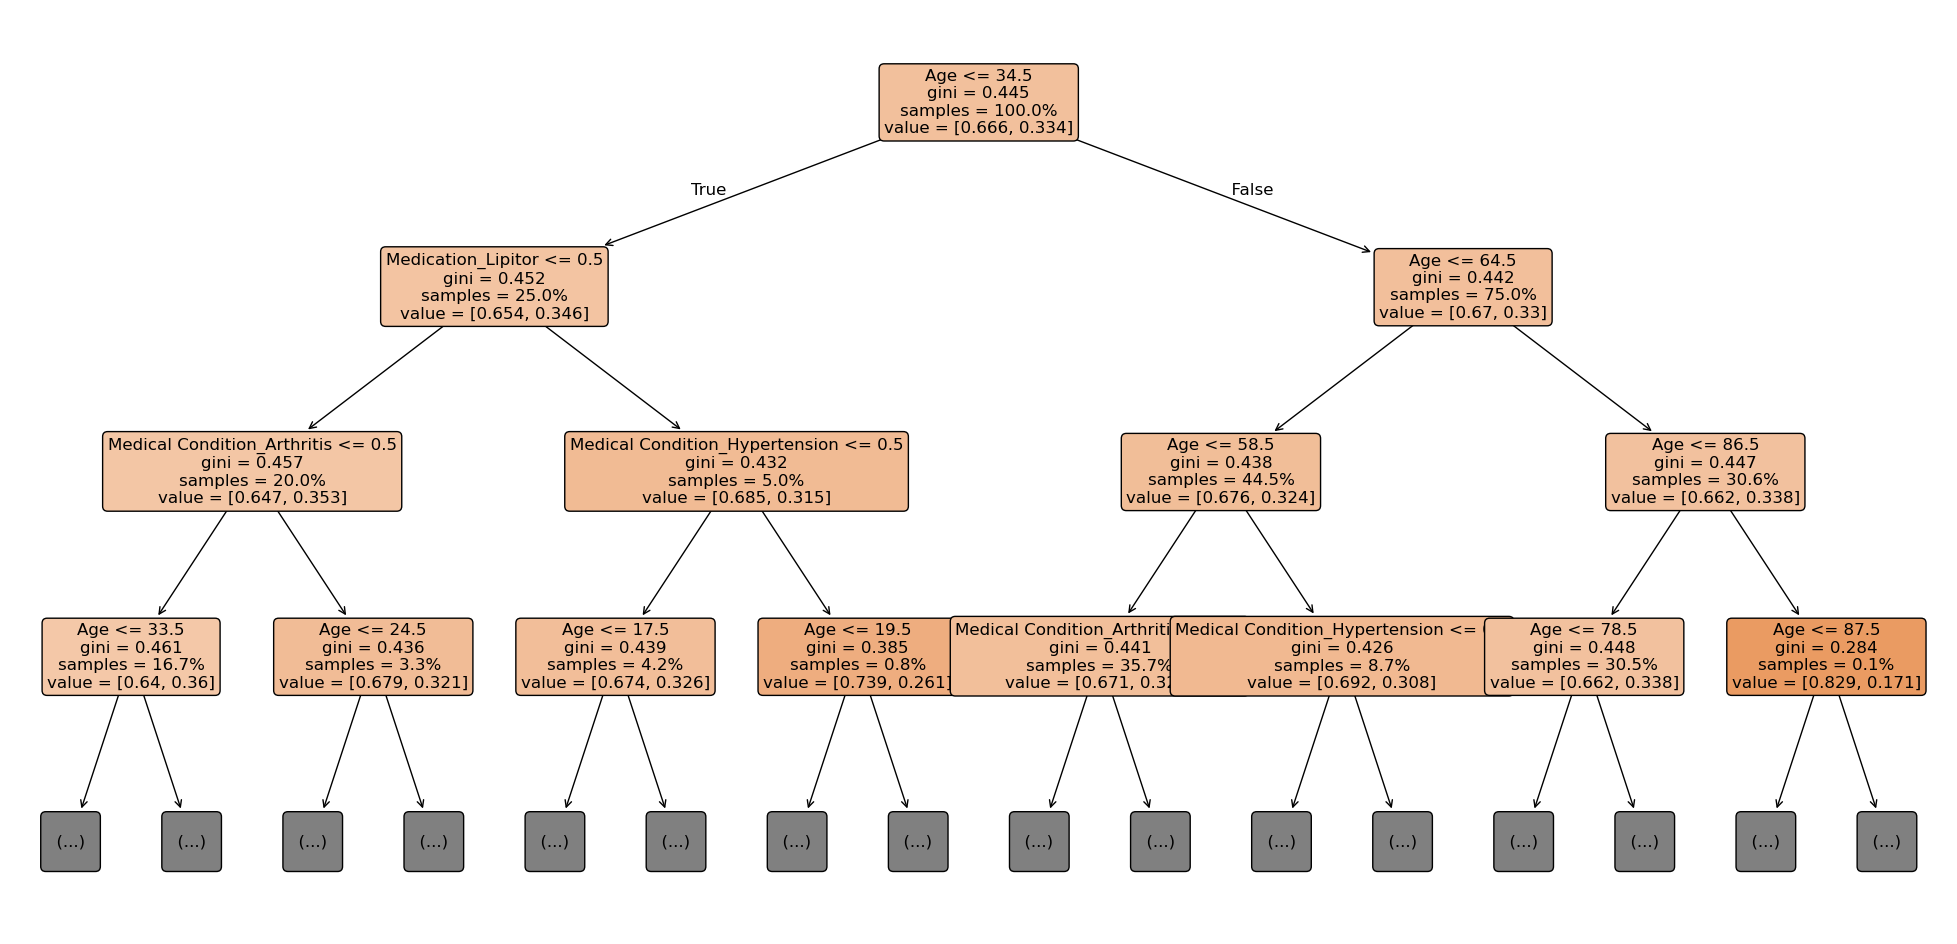

In [77]:
# Plot tree 
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(
    decision_tree=final_model.named_steps["decisiontreeclassifier"],
    feature_names=list(final_model.named_steps["onehotencoder"].get_feature_names_out()),
    filled =True, 
    rounded=True, 
    proportion=True,
    max_depth=3,
    fontsize=12,
    ax=ax
);


In [84]:
features = list(final_model.named_steps["onehotencoder"].get_feature_names_out())
importances = final_model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("importances:", importances[:3])

Features: ['Age', 'Medical Condition_Obesity', 'Medical Condition_Arthritis']
importances: [0.69422823 0.         0.09242858]


In [86]:
feat_imp = pd.Series(importances, index=features).sort_values().tail()

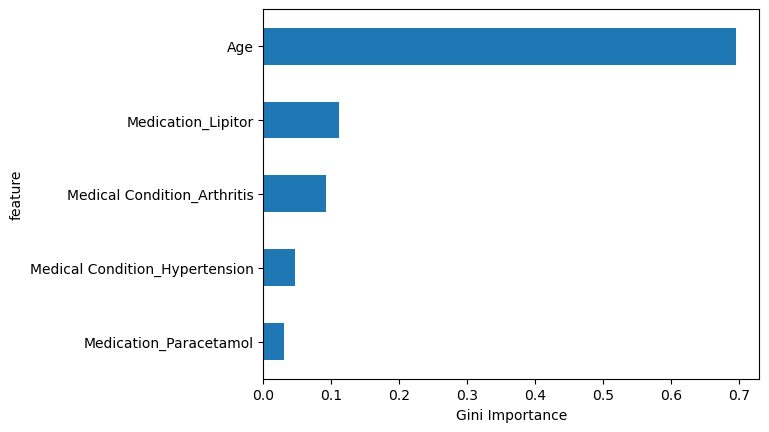

In [88]:
feat_imp.plot(kind="barh", xlabel="Gini Importance", ylabel="feature");